In [2]:
# Environment check & basic imports

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os

# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# If GPU exists, print its name
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


PyTorch version: 2.9.1+cpu
Using device: cpu


In [3]:
# Dataset paths and sanity check

# CHANGE THIS if your dataset folder has a different name or location
DATASET_ROOT = r"D:\New folder\dataset"


splits = ["train", "val", "test"]
classes = ["diabetes", "non_diabetes"]

for split in splits:
    print(f"\n📂 {split.upper()} SET")
    for cls in classes:
        path = os.path.join(DATASET_ROOT, split, cls)
        
        if not os.path.exists(path):
            print(f"❌ Missing folder: {path}")
        else:
            num_images = len(os.listdir(path))
            print(f"✅ {cls}: {num_images} images")



📂 TRAIN SET
✅ diabetes: 1540 images
✅ non_diabetes: 1540 images

📂 VAL SET
✅ diabetes: 350 images
✅ non_diabetes: 350 images

📂 TEST SET
✅ diabetes: 35 images
✅ non_diabetes: 35 images


In [4]:
#  Image preprocessing without augmentation

from torchvision import transforms

IMAGE_SIZE = 224

# Same preprocessing for train, validation, and test
common_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet mean
        std=[0.229, 0.224, 0.225]     # ImageNet std
    )
])

print("Image preprocessing defined successfully ✅")

Image preprocessing defined successfully ✅


In [5]:
# CELL 4: Dataset loading and DataLoaders (no label swapping)

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# --- Parameters ---
BATCH_SIZE = 16  # Safe for CPU

# Dataset paths
train_path = os.path.join(DATASET_ROOT, "train")
val_path   = os.path.join(DATASET_ROOT, "val")
test_path  = os.path.join(DATASET_ROOT, "test")

# --- Load datasets ---
# Use the common_transforms we defined in CELL 3
train_dataset = ImageFolder(root=train_path, transform=common_transforms)
val_dataset   = ImageFolder(root=val_path,   transform=common_transforms)
test_dataset  = ImageFolder(root=test_path,  transform=common_transforms)

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# --- Display info ---
class_names = train_dataset.classes  # automatically from folder names
print("Class names (as assigned by ImageFolder):", class_names)
print(f"\nTrain samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Class names (as assigned by ImageFolder): ['diabetes', 'non_diabetes']

Train samples: 3080
Validation samples: 700
Test samples: 70


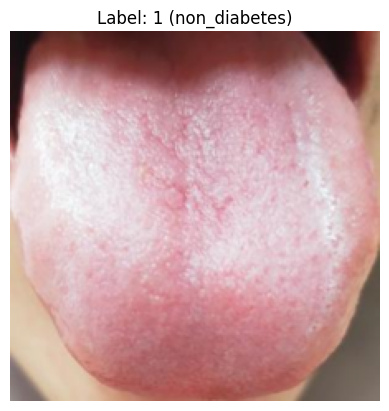

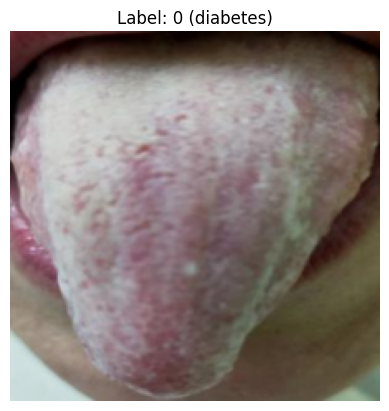

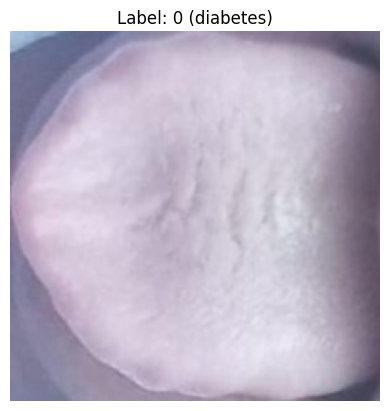

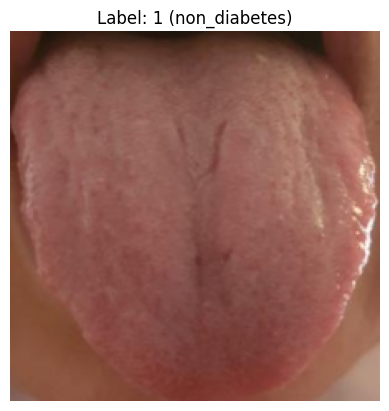

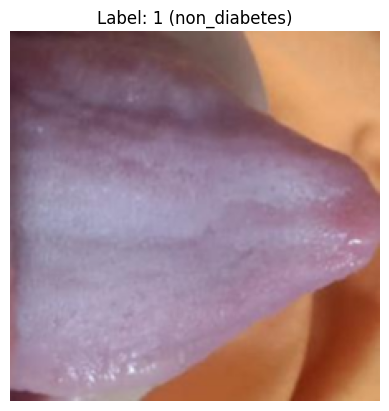

In [21]:
# Visualize some sample images from the training set

import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img, label):
    # Unnormalize
    img = img.numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title(f"Label: {label} ({class_names[label]})")
    plt.axis('off')
    plt.show()

# Get a batch from the training loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display first 5 images
for i in range(5):
    imshow(images[i], labels[i])


In [6]:
# 6: Build the CNN model (ResNet18, pretrained)

import torch.nn as nn
import torchvision.models as models

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze early layers (optional, speeds up training)
for param in model.parameters():
    param.requires_grad = True  # Set to False if you want to freeze

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: diabetes, non_diabetes

# Move model to device 
model = model.to(device)

# Print model summary 
print(model)


c:\Users\gigabite\AppData\Local\Programs\Python\Python314\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gigabite\AppData\Local\Programs\Python\Python314\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# 7: Loss function and optimizer

import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("Loss function and optimizer defined successfully ✅")


Loss function and optimizer defined successfully ✅


In [24]:
# CELL 8: Training loop

from tqdm import tqdm  # for progress bar

# Number of epochs
num_epochs = 10

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels).item()
    return correct / labels.size(0)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        train_loss += loss.item() * images.size(0)
        train_acc += calculate_accuracy(outputs, labels) * images.size(0)

    train_loss /= len(train_dataset)
    train_acc  /= len(train_dataset)

    # Validation
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_acc  += calculate_accuracy(outputs, labels) * images.size(0)

    val_loss /= len(val_dataset)
    val_acc  /= len(val_dataset)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10: 100%|██████████| 193/193 [03:32<00:00,  1.10s/it]


Epoch 1/10 | Train Loss: 0.2093, Train Acc: 0.9117 | Val Loss: 0.1505, Val Acc: 0.9343


Epoch 2/10: 100%|██████████| 193/193 [03:15<00:00,  1.01s/it]


Epoch 2/10 | Train Loss: 0.0494, Train Acc: 0.9834 | Val Loss: 0.1381, Val Acc: 0.9443


Epoch 3/10: 100%|██████████| 193/193 [03:14<00:00,  1.01s/it]


Epoch 3/10 | Train Loss: 0.0294, Train Acc: 0.9916 | Val Loss: 0.0834, Val Acc: 0.9700


Epoch 4/10: 100%|██████████| 193/193 [03:14<00:00,  1.01s/it]


Epoch 4/10 | Train Loss: 0.0219, Train Acc: 0.9932 | Val Loss: 0.0677, Val Acc: 0.9686


Epoch 5/10: 100%|██████████| 193/193 [03:15<00:00,  1.01s/it]


Epoch 5/10 | Train Loss: 0.0149, Train Acc: 0.9938 | Val Loss: 0.0370, Val Acc: 0.9814


Epoch 6/10: 100%|██████████| 193/193 [03:16<00:00,  1.02s/it]


Epoch 6/10 | Train Loss: 0.0268, Train Acc: 0.9903 | Val Loss: 0.0417, Val Acc: 0.9800


Epoch 7/10: 100%|██████████| 193/193 [03:18<00:00,  1.03s/it]


Epoch 7/10 | Train Loss: 0.0459, Train Acc: 0.9831 | Val Loss: 0.0378, Val Acc: 0.9871


Epoch 8/10: 100%|██████████| 193/193 [03:15<00:00,  1.02s/it]


Epoch 8/10 | Train Loss: 0.0175, Train Acc: 0.9945 | Val Loss: 0.1081, Val Acc: 0.9714


Epoch 9/10: 100%|██████████| 193/193 [03:17<00:00,  1.02s/it]


Epoch 9/10 | Train Loss: 0.0176, Train Acc: 0.9935 | Val Loss: 0.0415, Val Acc: 0.9829


Epoch 10/10: 100%|██████████| 193/193 [03:14<00:00,  1.01s/it]


Epoch 10/10 | Train Loss: 0.0066, Train Acc: 0.9987 | Val Loss: 0.0206, Val Acc: 0.9914


In [25]:
# Save the trained model
torch.save(model.state_dict(), "diabetes_model.pth")


In [8]:
# Load model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model.load_state_dict(torch.load("diabetes_model.pth"))
model = model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

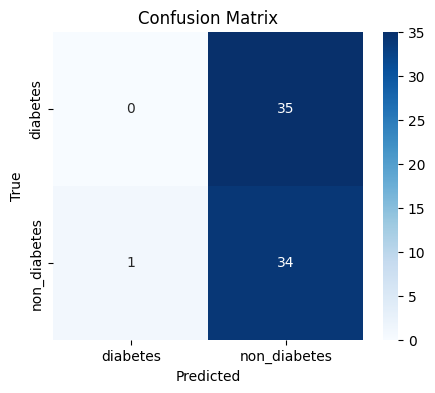

Classification Report:
              precision    recall  f1-score   support

    diabetes       0.00      0.00      0.00        35
non_diabetes       0.49      0.97      0.65        35

    accuracy                           0.49        70
   macro avg       0.25      0.49      0.33        70
weighted avg       0.25      0.49      0.33        70



In [9]:
# CELL 9: Evaluate the loaded model on the test set

import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- Classification Report ---
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


In [11]:
# SINGLE-CELL INFERENCE ON NEW IMAGES

import torch
from PIL import Image
import torchvision.transforms as transforms
import os

# Make sure model is in eval mode
model.eval()

# Same preprocessing used in training
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Class names (ORDER MATTERS)
class_names = ['diabetes', 'non_diabetes']

# Folder containing new images
TEST_IMAGE_FOLDER = r"D:\test"   # 🔁 change this

# Loop over images
for img_name in os.listdir(TEST_IMAGE_FOLDER):
    img_path = os.path.join(TEST_IMAGE_FOLDER, img_name)
    
    # Load image
    image = Image.open(img_path).convert("RGB")
    image_tensor = inference_transform(image).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.softmax(outputs, dim=1)
        confidence, pred = torch.max(probs, 1)

    print(f"Image: {img_name}")
    print(f"Prediction: {class_names[pred.item()]}")
    print(f"Confidence: {confidence.item()*100:.2f}%")
    print("-" * 40)


Image: d_-202-_jpg.rf.1a9cf063e8a8292a2ab3a27109d62123.jpg
Prediction: non_diabetes
Confidence: 63.31%
----------------------------------------
Image: e18749445402607_F2.jpg
Prediction: non_diabetes
Confidence: 60.06%
----------------------------------------
Image: F1.medium.gif
Prediction: non_diabetes
Confidence: 57.66%
----------------------------------------
Image: healthy-tongue-1.webp
Prediction: non_diabetes
Confidence: 74.70%
----------------------------------------
Image: Healthy-tongue-1296x728-gallery_slide1.jpg
Prediction: non_diabetes
Confidence: 79.04%
----------------------------------------
Image: Oral_Thrush_480x480.png
Prediction: non_diabetes
Confidence: 67.48%
----------------------------------------
Image: young-cool-woman-joke-close-up-min-scaled-1.jpg
Prediction: non_diabetes
Confidence: 77.47%
----------------------------------------
